## Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import feature_selection
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from sklearn import ensemble
from sklearn import tree

from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv

from xgboost import XGBClassifier

from utils import plot_confusion_matrix, print_feature_importance

## Data Loading

In [114]:
# load data
# CSV_FILE = "mafaulda_48khz_500ms_25ms_40-mfcc.csv"    # best until now
CSV_FILE = "mafaulda_16khz_500ms_20ms_40-mfcc.csv"
df = pd.read_csv(CSV_FILE)
df.head()

,mean,median,variance,standard_deviation,skewness,kurtosis,energy,power,min,max,...,delta_delta_mfcc_33,delta_delta_mfcc_34,delta_delta_mfcc_35,delta_delta_mfcc_36,delta_delta_mfcc_37,delta_delta_mfcc_38,delta_delta_mfcc_39,delta_delta_mfcc_40,class,label
0,0.007175,-0.005000,0.003303,0.057475,0.773794,1.274474,26.839275,0.003355,-0.165512,0.357898,...,-0.100335,0.396085,0.075804,-0.152675,0.125347,0.082942,-0.185454,-0.14491,0,normal
1,0.006753,-0.005486,0.003267,0.057155,0.782336,1.187094,26.498035,0.003312,-0.156350,0.357898,...,-0.100335,0.396085,0.075804,-0.152675,0.125347,0.082942,-0.185454,-0.14491,0,normal
2,0.006776,-0.005862,0.003269,0.057176,0.783406,1.256886,26.520110,0.003315,-0.165477,0.356079,...,-0.100335,0.396085,0.075804,-0.152675,0.125347,0.082942,-0.185454,-0.14491,0,normal
3,0.007155,-0.005575,0.003302,0.057466,0.747313,1.060964,26.828390,0.003354,-0.165427,0.334963,...,-0.100335,0.396085,0.075804,-0.152675,0.125347,0.082942,-0.185454,-0.14491,0,normal
4,0.006859,-0.005442,0.003247,0.056985,0.794196,1.276458,26.354824,0.003294,-0.164204,0.343283,...,-0.100335,0.396085,0.075804,-0.152675,0.125347,0.082942,-0.185454,-0.14491,0,normal


In [115]:
# load feature matrix, class vector, features list and labels from .csv file
X = df.drop(["class", "label"], axis=1).values
y = df["class"].values
FEATURES_LST = [column for column in df.columns if column not in ["class", "label"]]
labels = list(df["label"].unique())

## Data Normalization / Standardization

In [116]:
scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X)

## Data splitting into training and test sets

In [117]:
# splitting the data into training and test sets
TEST_SIZE = 0.20
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Cross-validation Configuration

In [118]:
# defining the cross-validation strategy
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Classification and Results

### XGBoost Classifier

Acc per fold: ['0.9911', '0.9947', '0.9907', '0.9943', '0.9922']
Mean accuracy: 0.9926
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.99      1.00      0.99       339
           2       1.00      1.00      1.00       559
           3       0.99      0.99      0.99       595
           4       1.00      0.99      1.00       944
           5       0.99      0.99      0.99       985

    accuracy                           1.00      3512
   macro avg       1.00      1.00      1.00      3512
weighted avg       1.00      1.00      1.00      3512



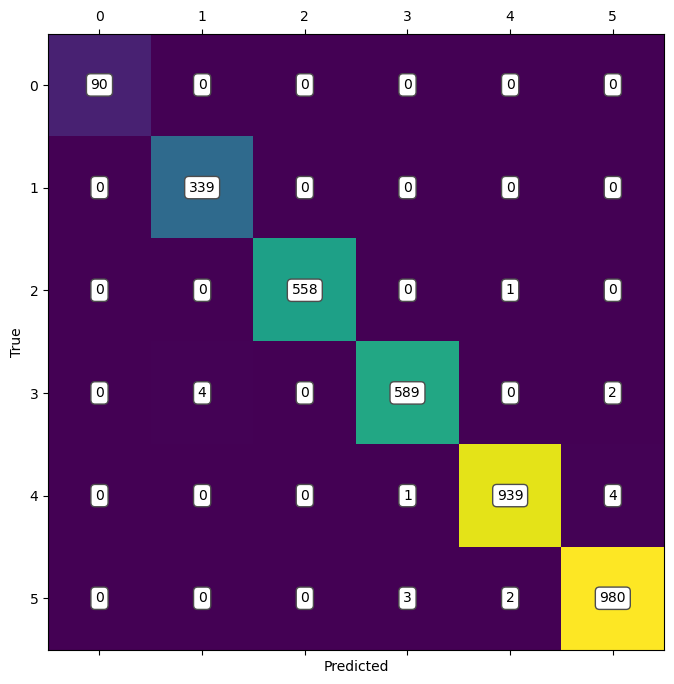

spectral_rolloff:    0.2289
mfcc_4:              0.0771
kurtosis:            0.0543
spectral_flatness:   0.0501
peak_to_peak:        0.0342
median:              0.0329
skewness:            0.0310
mfcc_1:              0.0295
mfcc_5:              0.0281
mfcc_2:              0.0249
max:                 0.0244
energy:              0.0195
spectral_centroid:   0.0174
power:               0.0172
mfcc_10:             0.0149
mfcc_14:             0.0145
mean:                0.0144
variance:            0.0140
mfcc_6:              0.0138
zero_crossing_rate:  0.0133
mfcc_3:              0.0113
mfcc_8:              0.0102
mfcc_9:              0.0100
mfcc_7:              0.0094
mfcc_16:             0.0086
mfcc_12:             0.0066
mfcc_24:             0.0062
mfcc_19:             0.0054
mfcc_15:             0.0053
mfcc_11:             0.0052
mfcc_31:             0.0051
min:                 0.0051
mfcc_26:             0.0051
mfcc_36:             0.0048
delta_mfcc_40:       0.0044
delta_mfcc_17:      

In [119]:
xgbc = XGBClassifier(n_estimators=40, max_depth=4, learning_rate=1.0, objective="multi:softmax", device="cuda")
xgbc.set_params(device="cuda")
xgbc_cv_scores = model_selection.cross_val_score(xgbc, X_train, y_train, cv=skf)

# fitting the decision tree classifier
trained_model_xgbc = xgbc.fit(X_train, y_train)
trained_model_xgbc.set_params(device="cuda")
y_pred_xgbc = trained_model_xgbc.predict(X_test)

# cross-validation results
print(f"Acc per fold: {[f'{s:.4f}' for s in xgbc_cv_scores]}")
print(f"Mean accuracy: {xgbc_cv_scores.mean():.4f}")

print("Classification report:")
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_xgbc))

# plotting confusion matrix
plot_confusion_matrix(  y_true=y_test,
                        y_pred=y_pred_xgbc,
                        labels=list(set(y)),
                        color_map="viridis",
                        print_colorbar=False,
                        print_numbers=True,
                        print_boxes=True)

# printing feature importance (ordered by values)
print_feature_importance(FEATURES_LST, trained_model_xgbc.feature_importances_, order_by='values', ascending=False)

In [9]:
pipeline = Pipeline([
    ('feature_selection', feature_selection.SelectKBest()),
    ('clf', XGBClassifier(n_estimators=40, max_depth=4, learning_rate=1.0, objective="multi:softmax", device="cuda"))
])

param_grid = {
    'feature_selection__k': range(1, X.shape[1]+1)
}

grid_search = model_selection.GridSearchCV(pipeline, param_grid, cv=skf, verbose=10)
grid_search.fit(X, y)

print("Best params:")
print(grid_search.best_params_)
print("Best score:")
print(grid_search.best_score_)

results = grid_search.cv_results_

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 1/5; 1/143] START feature_selection__k=1....................................
[CV 1/5; 1/143] END .....feature_selection__k=1;, score=0.381 total time=   0.9s
[CV 2/5; 1/143] START feature_selection__k=1....................................
[CV 2/5; 1/143] END .....feature_selection__k=1;, score=0.391 total time=   0.8s
[CV 3/5; 1/143] START feature_selection__k=1....................................
[CV 3/5; 1/143] END .....feature_selection__k=1;, score=0.401 total time=   0.9s
[CV 4/5; 1/143] START feature_selection__k=1....................................
[CV 4/5; 1/143] END .....feature_selection__k=1;, score=0.396 total time=   0.8s
[CV 5/5; 1/143] START feature_selection__k=1....................................
[CV 5/5; 1/143] END .....feature_selection__k=1;, score=0.389 total time=   0.8s
[CV 1/5; 2/143] START feature_selection__k=2....................................
[CV 1/5; 2/143] END .....feature_selection__k=

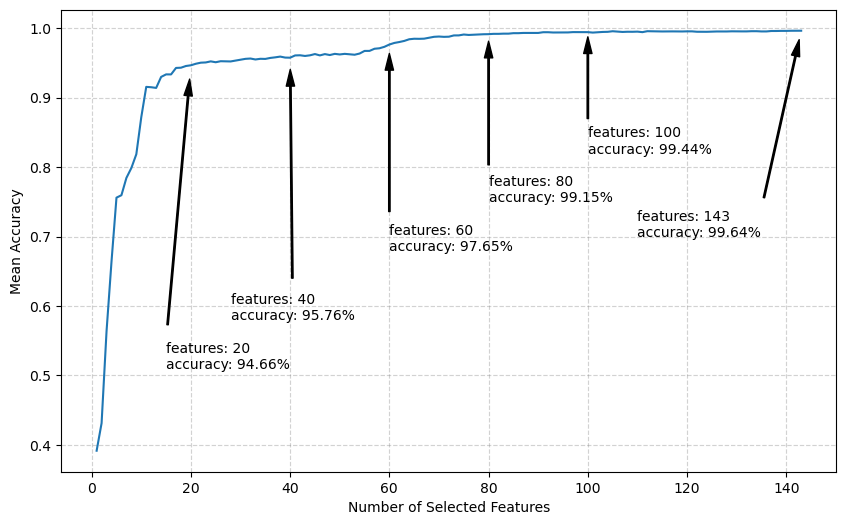

In [79]:
results = grid_search.cv_results_

n_features = list(range(1, X.shape[1]+1))

accuracy_scores = []
for i in range(len(results['params'])):
    feature_selector = results['params'][i]['feature_selection__k']
    mean_test_score_key = f"split0_test_score_{i}"
    mean_test_scores = [results[f"split{k}_test_score"][i] for k in range(5)]
    accuracy = np.mean(mean_test_scores)
    accuracy_scores.append(accuracy)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, X.shape[1]+1), accuracy_scores)
ax.set_xlabel('Number of Selected Features')
ax.set_ylabel('Mean Accuracy')
ax.grid(linestyle='--', linewidth=0.85, color='gray', alpha=0.35, zorder=0)

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[20-1], accuracy_scores[20-1] * 100), xy=(n_features[20-1], accuracy_scores[20-1]), xytext=(15, 0.510),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[40-1], accuracy_scores[40-1] * 100), xy=(n_features[40-1], accuracy_scores[40-1]), xytext=(28, 0.580),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[60-1], accuracy_scores[60-1] * 100), xy=(n_features[60-1], accuracy_scores[60-1]), xytext=(60, 0.680),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[80-1], accuracy_scores[80-1] * 100), xy=(n_features[80-1], accuracy_scores[80-1]), xytext=(80, 0.750),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[100-1], accuracy_scores[100-1] * 100), xy=(n_features[100-1], accuracy_scores[100-1]), xytext=(100, 0.820),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("features: {}\naccuracy: {:.2f}%".format(n_features[-1], accuracy_scores[-1] * 100), xy=(n_features[-1], accuracy_scores[-1]), xytext=(110, 0.7),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

plt.show()

In [12]:
estimators = []
accuracies = []
for n_estimators in range(1, 100+1, 1):
    xgbc = XGBClassifier(n_estimators=n_estimators, max_depth=4, learning_rate=1.0, objective="multi:softmax", device="cuda")
    xgbc.set_params(device="cuda")
    xgbc_cv_scores = model_selection.cross_val_score(xgbc, X_train, y_train, cv=skf)
    estimators.append(n_estimators)
    accuracies.append(xgbc_cv_scores.mean())
    print(f"n_estimators: {n_estimators}, accuracy: {xgbc_cv_scores.mean():.4f}")

# # fitting the decision tree classifier
# trained_model_xgbc = xgbc.fit(X_train, y_train)
# trained_model_xgbc.set_params(device="cuda")
# y_pred_xgbc = trained_model_xgbc.predict(X_test)

# # cross-validation results
# print(f"Acc per fold: {[f'{s:.4f}' for s in xgbc_cv_scores]}")
# print(f"Mean accuracy: {xgbc_cv_scores.mean():.4f}")

# print("Classification report:")
# print(metrics.classification_report(y_true=y_test, y_pred=y_pred_xgbc))

# # plotting confusion matrix
# plot_confusion_matrix(  y_true=y_test,
#                         y_pred=y_pred_xgbc,
#                         labels=list(set(y)),
#                         color_map="viridis",
#                         print_colorbar=False,
#                         print_numbers=True,
#                         print_boxes=True)

# # printing feature importance (ordered by values)
# print_feature_importance(FEATURES_LST, trained_model_xgbc.feature_importances_, order_by='values', ascending=False)

n_estimators: 1, accuracy: 0.7775
n_estimators: 2, accuracy: 0.8413
n_estimators: 3, accuracy: 0.8719
n_estimators: 4, accuracy: 0.8973
n_estimators: 5, accuracy: 0.9154
n_estimators: 6, accuracy: 0.9295
n_estimators: 7, accuracy: 0.9417
n_estimators: 8, accuracy: 0.9509
n_estimators: 9, accuracy: 0.9580
n_estimators: 10, accuracy: 0.9640
n_estimators: 11, accuracy: 0.9681
n_estimators: 12, accuracy: 0.9707
n_estimators: 13, accuracy: 0.9743
n_estimators: 14, accuracy: 0.9771
n_estimators: 15, accuracy: 0.9792
n_estimators: 16, accuracy: 0.9817
n_estimators: 17, accuracy: 0.9828
n_estimators: 18, accuracy: 0.9845
n_estimators: 19, accuracy: 0.9862
n_estimators: 20, accuracy: 0.9873
n_estimators: 21, accuracy: 0.9890
n_estimators: 22, accuracy: 0.9897
n_estimators: 23, accuracy: 0.9901
n_estimators: 24, accuracy: 0.9913
n_estimators: 25, accuracy: 0.9915
n_estimators: 26, accuracy: 0.9918
n_estimators: 27, accuracy: 0.9924
n_estimators: 28, accuracy: 0.9925
n_estimators: 29, accuracy: 0

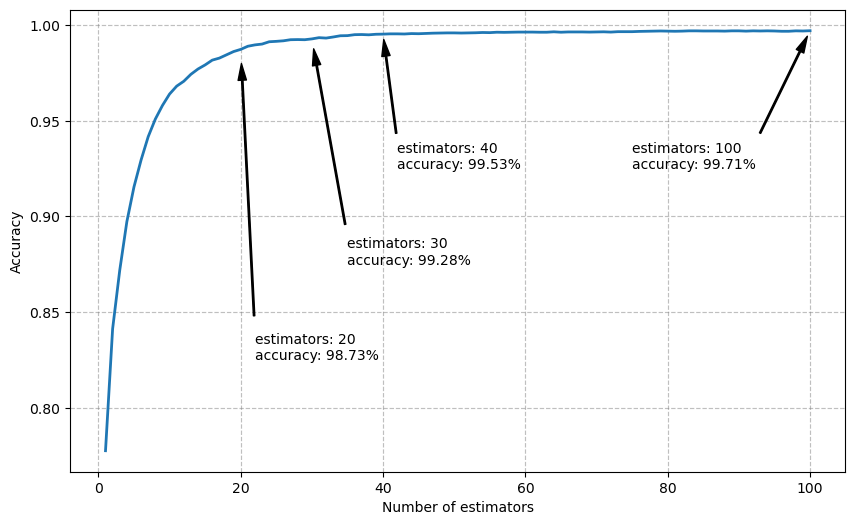

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(estimators, accuracies, linewidth=2, color="C0")
ax.grid(linestyle='--', linewidth=0.85, color='gray', alpha=0.5, zorder=0)

ax.annotate("estimators: {}\naccuracy: {:.2f}%".format(estimators[20-1], accuracies[20-1] * 100), xy=(estimators[20-1], accuracies[20-1]), xytext=(22, 0.825),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("estimators: {}\naccuracy: {:.2f}%".format(estimators[30-1], accuracies[30-1] * 100), xy=(estimators[30-1], accuracies[30-1]), xytext=(35, 0.875),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("estimators: {}\naccuracy: {:.2f}%".format(estimators[40-1], accuracies[40-1] * 100), xy=(estimators[40-1], accuracies[40-1]), xytext=(42, 0.925),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.annotate("estimators: {}\naccuracy: {:.2f}%".format(estimators[-1], accuracies[-1] * 100), xy=(estimators[-1], accuracies[-1]), xytext=(75, 0.925),
            arrowprops=dict(facecolor='black', width=1, headwidth=6, shrink=0.05),
            )

ax.set(xlabel="Number of estimators", ylabel="Accuracy")
plt.show()

### Decision Tree

In [7]:
# fitting the decision tree classifier
clf_tree = tree.DecisionTreeClassifier()
fdtree_cv_scores = model_selection.cross_val_score(clf_tree, X_train, y_train, cv=skf)

# fitting the decision tree classifier
trained_model_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = trained_model_tree.predict(X_test)

# tree params
print(f"Tree Max Depth: {trained_model_tree.tree_.max_depth}")
print(f"Tree Leaves:    {trained_model_tree.tree_.n_leaves}")
print(f"--------------")

# cross-validation results
print(f"Acc per fold: {[f'{s:.4f}' for s in fdtree_cv_scores]}")
print(f"Mean accuracy: {fdtree_cv_scores.mean():.4f}")

Tree Max Depth: 38
Tree Leaves:    1246
--------------
Acc per fold: ['0.8511', '0.8560', '0.8609', '0.8551', '0.8580']
Mean accuracy: 0.8562


In [8]:
# printing feature importance (ordered by values)
print_feature_importance(FEATURES_LST, clf_tree.feature_importances_, order_by='values', ascending=False)

kurtosis:            0.1052
mfcc_1:              0.0830
median:              0.0811
mfcc_4:              0.0720
spectral_centroid:   0.0574
skewness:            0.0536
zero_crossing_rate:  0.0494
mfcc_3:              0.0489
root_mean_square:    0.0409
mfcc_5:              0.0319
energy:              0.0308
mfcc_2:              0.0241
mfcc_8:              0.0216
mean:                0.0190
standard_deviation:  0.0185
mfcc_9:              0.0156
mfcc_16:             0.0156
mfcc_7:              0.0143
mfcc_10:             0.0128
variance:            0.0118
mfcc_6:              0.0114
power:               0.0102
mfcc_15:             0.0099
mfcc_13:             0.0088
peak_to_peak:        0.0082
max:                 0.0066
mfcc_12:             0.0065
mfcc_11:             0.0052
spectral_flatness:   0.0052
mfcc_14:             0.0051
mfcc_19:             0.0050
min:                 0.0046
mfcc_20:             0.0045
delta_mfcc_4:        0.0045
delta_delta_mfcc_3:  0.0040
mfcc_17:            

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       105
           1       0.73      0.75      0.74       400
           2       0.93      0.90      0.92       682
           3       0.75      0.75      0.75       755
           4       0.88      0.90      0.89      1133
           5       0.93      0.92      0.93      1205

    accuracy                           0.86      4280
   macro avg       0.80      0.80      0.80      4280
weighted avg       0.86      0.86      0.86      4280



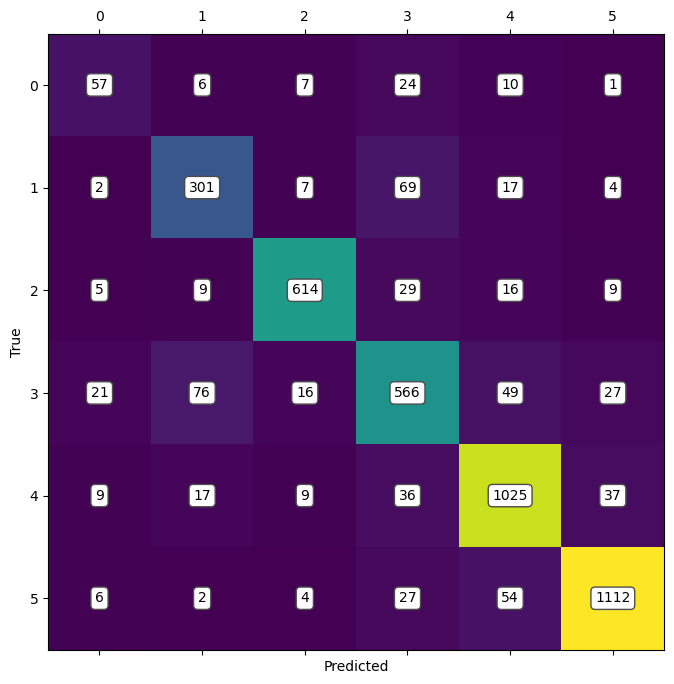

In [9]:
# printing classification report
print("Classification report:")
print(metrics.classification_report(y_true=y_test, y_pred=y_pred_tree))

# plotting confusion matrix
plot_confusion_matrix(  y_true=y_test,
                        y_pred=y_pred_tree,
                        labels=list(set(y)),
                        color_map="viridis",
                        print_colorbar=False,
                        print_numbers=True,
                        print_boxes=True)

### Random Forest

In [15]:
# Setting classifiers and its configurations
classifiers = [
    {
        'preprocessing': [  preprocessing.RobustScaler()
                            ],
        'feature_selection': [  feature_selection.RFE(ensemble.RandomForestClassifier(), n_features_to_select=20)
                                ],
        'classifier': [ensemble.RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__bootstrap': [False],
        'classifier__criterion': ['gini', 'entropy']
    }
]

# Creating pipeline with a standard classifier
pipeline = Pipeline([
    ('preprocessing',       preprocessing.RobustScaler()),
    ('feature_selection',   feature_selection.RFE(ensemble.RandomForestClassifier(), n_features_to_select=20)),
    ('classifier',          ensemble.RandomForestClassifier())
])

# Creating GridSearchCV object
grid_search = model_selection.GridSearchCV(pipeline, classifiers, cv=5, n_jobs=-1)

# Fitting GridSearchCV to data
grid_search.fit(X_train, y_train)

# Results
print("Best parameters:",   grid_search.best_params_)
print("Best classifier:",   grid_search.best_estimator_)
print("Best score:",        grid_search.best_score_)

Best parameters: {'classifier': RandomForestClassifier(), 'classifier__bootstrap': False, 'classifier__criterion': 'entropy', 'classifier__n_estimators': 200, 'feature_selection': RFE(estimator=RandomForestClassifier(), n_features_to_select=20), 'preprocessing': RobustScaler()}
Best classifier: Pipeline(steps=[('preprocessing', RobustScaler()),
                ('feature_selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=20)),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        n_estimators=200))])
Best score: 0.9527953597298101


In [18]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing', RobustScaler()),
                ('feature_selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=20)),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        n_estimators=200))])

In [26]:
for i, score in enumerate(grid_search.cv_results_['split0_test_score']):
    print(f"Fold {i+1:2}: {score * 100:.4f} %")

Fold  1: 95.2395 %
Fold  2: 94.9474 %
Fold  3: 95.1227 %
Fold  4: 95.4731 %
Fold  5: 95.1811 %
Fold  6: 94.9474 %
Fold  7: 95.4147 %
Fold  8: 95.7360 %
Fold  9: 95.5315 %
Fold 10: 95.4439 %


In [19]:
print("Classification report:")
print(metrics.classification_report(y_true=y_test, y_pred=grid_search.best_estimator_.predict(X_test)))

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       105
           1       0.92      0.90      0.91       400
           2       0.99      0.98      0.98       682
           3       0.87      0.91      0.89       755
           4       0.98      0.98      0.98      1133
           5       0.98      0.98      0.98      1205

    accuracy                           0.95      4280
   macro avg       0.94      0.90      0.92      4280
weighted avg       0.95      0.95      0.95      4280



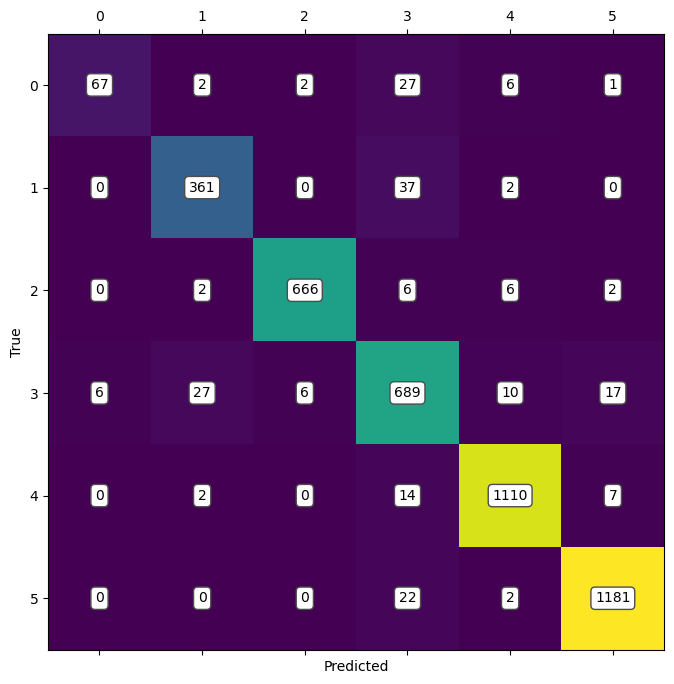

In [20]:
plot_confusion_matrix(  y_true=y_test,
                        y_pred=grid_search.best_estimator_.predict(X_test),
                        labels=list(set(y)),
                        color_map="viridis",
                        print_colorbar=False,
                        print_numbers=True,
                        print_boxes=True)